## Introduction


## Importance

The polynomial models we use in our Dirac-3 device are continuous rather than discrete models. While perhaps not the most common setting in optimization, they are very powerful, and the multibody terms make them even more powerful. Formally,even a simple quadratic-only version of our quadratic model is already NP-hard 
 minimise $X^TQX$ where $X\ge 0$.
This fact was shown in [this paper](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/6740/bam7058.0001.001.pdf?sequence=5) (and section 2.9.3 of [this book](https://public.websites.umich.edu/~murty/books/linear_complementarity_webbook/lcp-complete.pdf)), this essentially means that it is a rich enough optimisation problem that all other hard optimization can be mapped to it, the details of the theory is explained in this lesson. Being NP-hard is important because it shows that even a more limited (quadratic only) version of our model is already rich enough to map interesting problems to. The restricted range plays a key role in the richness of the model particularly the version with unrestricted values of $X$
 minimise $X^TQX$ where $X$ can take any real values
is not NP-hard, in other words not rich enough to represent hard optimisation problems, in fact this is essentially matrix diagonalisation which is performed efficiently by the ARPACK and LAPACK linear algebra libraries which are commonly used for example in Python. Even without the restricted range, adding fourth-order terms would also render the problem NP-hard, as discussed in [this paper](https://web.mit.edu/~a_a_a/Public/Publications/convexity_nphard.pdf).


## Applications

Optimisation over polynomials is a less explored topic than more traditional binary optimisation, however such problems are very important and arise naturally. One example discussed in [this paper](https://arxiv.org/abs/1504.06002) and [this paper](https://groups.csail.mit.edu/robotics-center/public_papers/Majumdar12a.pdf) which considers the problem of optimising drone paths while avoiding danger. In this example the parameters which are optmised over are the continous control inputs at all points, requiring good-quality solutions to polynomial optimisation problems in realy time. Problems related to wireless coverage, as discussed in [this paper](https://arxiv.org/abs/1504.06002) also naturally involve polynomial terms, in this case the experession for electromagnetic power being delivered to each location in a space becomes a polynomial constraint, which could be enforced using lagrange multipliers and a polynomial with a degree which is twice as large. 

### Tutorial preparation
Multi-body support was added to `qci-client` in version 3.2.0, but in order to utilize this tutorial, a version of `qci-client` of at least 4.0 is required.

In [1]:
!pip install --quiet "qci-client>=4.0"
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import qci_client as qc

# Multi-body Tutorial
Multi-body problems are polynomials where the total degree of at least one term in the polynomial is higher than 2. For instance 
$$
f(x,y)=xy^2-x^2y+x+y
$$ 
is a two variable, cubic problem.

## Optimization

Dirac-3 is a purpose-built device for finding global minima of a polynomial function. As demonstrated in the [Dirac-3 Quick Start](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/dirac-3-quick-start), it optimizes a multi-variate polynomial over a domain $x_i\in[0,R]\, i\in[0,1,\ldots,N-1]$ where $R$ is a positive value all $x_i$ must sum to.

## Example
Observe the following visualization of the function. The surface with the jet color scale describes the function across the entire domain $0\leq x\leq 10, 0\leq y\leq 10$, while the surface in semi transparent blue shows the domain of the optimization problem with the sum constraint of $x+y=10$. Notice the cross section with two extrema due to the cubic curvature indicates the function range Dirac-3 samples.

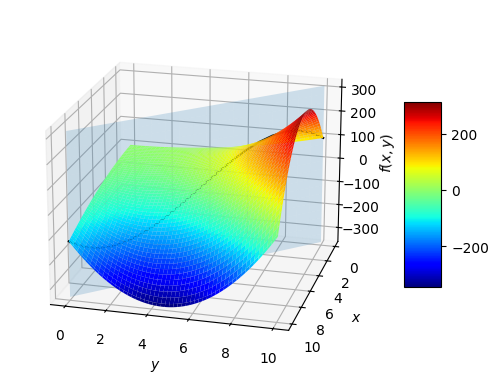

In [2]:
X = np.linspace(0, 10, 100)
Y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(X, Y)
Z = X*Y**2 - X**2*Y - X*X - 2*X +Y*Y
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surface = ax.plot_surface(X, Y, Z, cmap=cm.jet)

# Add a color bar which maps values to colors.
fig.colorbar(surface, shrink=0.5, aspect=5)
X2 = np.linspace(0, 10, 20)
Y2 = 10 - X2
Z2 = X2 * Y2 ** 2 - X2 ** 2 * Y2 - X2 ** 2 - 2 * X2 + Y2 ** 2
ax.plot3D(X2, Y2, Z2, "k-")
X3 = X2 * np.ones((20, 20))
Y3 = 10 - X3
Z3 = np.linspace(np.min(Z), np.max(Z), 20) * np.ones((20, 20))
sum_surface = ax.plot_surface(X3, Y3, Z3.T, alpha=0.2)
ax.view_init(azim=15, elev=20)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$f(x,y)$")
ax.zaxis.set_label_position("upper")
ax.zaxis.set_ticks_position("upper")


## Running the Problem
We will prepare data in a list and a list of lists, upload the polynomial file to Qatalyst and submit a job.

### QciClient Instantiation
This call to `QciClient` uses the environment variables `QCI_TOKEN` and `QCI_API_URL` to configure the API connection. It may also be called with `api_token` and `url` parameters to configure it explicitly. See the [Quick Start on Cloud](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/quick-start-on-cloud) tutorial for a deeper explanation on this configuration.


In [3]:
client = qc.QciClient()

### Polynomial Format
The ability to support higher order terms efficiently for the majority of problems requires a sparse format. That format is inspired by polynomials themselves. Two different arrays are required. The first is a coefficient array. Each term in the function has an entry in the coefficient array. The second array, the indices array, is where to indicate which term the corresponding coefficient is for. The second polynomial from above is presented here.

$$
f(x,y)=xy^2-x^2y+x+y
$$ 
is represented in polynomial format
```
poly_coefficients = [1, -1, 1, 1]
poly_indices = [[1, 2, 2], [1, 1, 2], [0, 0, 1], [0, 0, 2]]
```


In [4]:
poly_coefficients = [1, -1, 1, 1]
poly_indices = [[1, 2, 2], [1, 1, 2], [0, 0, 1], [0, 0, 2]]
data = []
for i in range(len(poly_coefficients)):
    data.append({
        "val": poly_coefficients[i],
        "idx": poly_indices[i]
    })
poly_file = {"file_name": "test-polynomial",
             "file_config": {"polynomial": {
                 "min_degree": 1,
                 "max_degree": 3,
                 "num_variables": 2,
                 "data": data
             }}}
file_id = client.upload_file(file=poly_file)["file_id"]
file_id

'6672ed6798263204a365ddc1'

In [5]:
poly_file

{'file_name': 'test-polynomial',
 'file_config': {'polynomial': {'min_degree': 1,
   'max_degree': 3,
   'num_variables': 2,
   'data': [{'val': 1, 'idx': [1, 2, 2]},
    {'val': -1, 'idx': [1, 1, 2]},
    {'val': 1, 'idx': [0, 0, 1]},
    {'val': 1, 'idx': [0, 0, 2]}]}}}

In [6]:
job_body = client.build_job_body(job_type="sample-hamiltonian", polynomial_file_id=file_id, job_params={"device_type": "dirac-3", "sum_constraint": 10, "solution_precision": 1, "relaxation_schedule": 1, "num_samples": 15})
job_body

{'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '6672ed6798263204a365ddc1'}},
  'device_config': {'dirac-3': {'num_samples': 15,
    'relaxation_schedule': 1,
    'solution_precision': 1,
    'sum_constraint': 10}}}}

In [7]:
response = client.process_job(job_body=job_body)

2024-06-19 08:38:31 - Dirac allocation balance = 0 s (unmetered)
2024-06-19 08:38:31 - Job submitted: job_id='6672ed67a3e6a645a5c4e7c5'
2024-06-19 08:38:31 - QUEUED
2024-06-19 08:38:34 - RUNNING
2024-06-19 08:38:55 - COMPLETED
2024-06-19 08:38:57 - Dirac allocation balance = 0 s (unmetered)


In [8]:
response

{'job_info': {'job_id': '6672ed67a3e6a645a5c4e7c5',
  'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '6672ed6798263204a365ddc1'}},
   'device_config': {'dirac-3': {'num_samples': 15,
     'relaxation_schedule': 1,
     'solution_precision': 1,
     'sum_constraint': 10}}},
  'job_status': {'submitted_at_rfc3339nano': '2024-06-19T14:38:31.913Z',
   'queued_at_rfc3339nano': '2024-06-19T14:38:31.913Z',
   'running_at_rfc3339nano': '2024-06-19T14:38:32.764Z',
   'completed_at_rfc3339nano': '2024-06-19T14:38:54.734Z'},
  'job_result': {'file_id': '6672ed7e98263204a365ddc3', 'device_usage_s': 20}},
 'status': 'COMPLETED',
 'results': {'counts': [4, 4, 2, 2, 2, 1],
  'energies': [-77.1194382,
   -84.6596832,
   -74.1873169,
   -83.8009644,
   -83.8447723,
   -86.1170654],
  'solutions': [[7.1276598, 2.8723404],
   [8.182374, 1.817626],
   [7.0072289, 2.9927711],
   [7.504097, 2.4959033],
   [7.5076513, 2.4923487],
   [7.8074245, 2.192

Dirac-3 has identified multiple solutions near the integer optimal solution `[8, 2]` with a value of -86 with some less than -86.

### Next Steps

Beyond two variables, visualization becomes tricky, but the value of the solver becomes higher. The current version of Dirac-3 supports 135 variables with rank 3 polynomials. 

Try experimenting with different polynomials using the format described.

## Conclusion

In this tutorial we have shown how to perform polynomial optimisation using multi-body terms on our our Dirac-3 device. While polynomial optimisation is less explored than conventional combinatorial optimisation, it is still a powerful paradigm. The importance of multibody (beyod quadratic) terms is highlighted by the fact that, while continuum quadratic optimisation (at least in the case of unbounded variables and no constraints), is known to be solvable using well established techniques, the addition of fourth order terms renders these problems NP-hard. This tutorial gives an example of how our hardware can be used to explore new frontiers in optimisation using cutting edge optical hardware.